In [15]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import numpy as np

import pymudokon as pm

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
particles_per_cell = 4

total_steps, output_steps, output_start = 3000, 100, 0

circle1_center = np.array([0.255, 0.255])
circle2_center = np.array([0.745, 0.745])
circle_radius = 0.2


In [17]:
def create_circle(center: np.array, radius: float, cell_size: float, ppc: int = 2):
    """Generate a circle of particles.

    Args:
        center (np.array): center of the circle
        radius (float): radius of the circle
        cell_size (float): size of the background grid cells
        ppc (int, optional): particles per cell. Defaults to 2.

    Returns:
        np.array: coordinates of the particles
    """
    start, end = center - radius, center + radius
    spacing = cell_size / (ppc / 2)
    tol = +0.00005  # Add a tolerance to avoid numerical issues
    x = np.arange(start[0], end[0] + spacing, spacing) + 0.5 * spacing
    y = np.arange(start[1], end[1] + spacing, spacing) + 0.5 * spacing
    xv, yv = np.meshgrid(x, y)
    grid_coords = np.array(list(zip(xv.flatten(), yv.flatten()))).astype(np.float64)
    circle_mask = (grid_coords[:, 0] - center[0]) ** 2 + (grid_coords[:, 1] - center[1]) ** 2 < radius**2 + tol
    return grid_coords[circle_mask]

In [18]:
# Create circles of particles and concatenate them into a single array
circle_centers = np.array([circle1_center, circle2_center])
cell_size = 0.05
particles_per_cell = 2


circles = [create_circle(center, circle_radius, cell_size, particles_per_cell) for center in circle_centers]
pos = np.vstack(circles)


velocities = [np.full(circle.shape, 0.1 if i == 0 else -0.1) for i, circle in enumerate(circles)]
vels = np.vstack(velocities)


[(0.0, 1.0), (0.0, 1.0)]

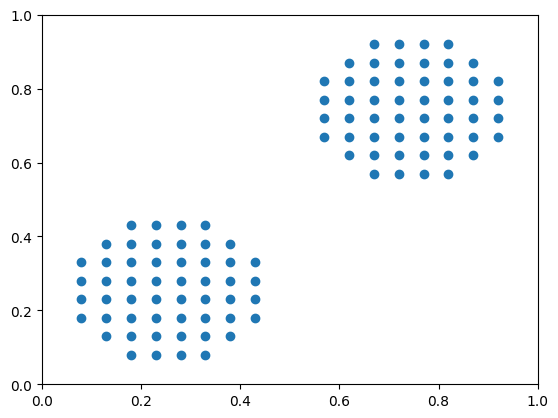

In [19]:
plt.scatter(pos[:,0], pos[:,1]).axes.set(xlim=(0, 1), ylim=(0, 1))

In [20]:
particles = pm.Particles.register(positions=jnp.array(pos), velocities=jnp.array(vels), original_density=1000)
particles = particles.calculate_volume(cell_size, particles_per_cell=4)
particles = particles.replace(masses=1000 * particles.volumes)
nodes = pm.Nodes.register(origin=jnp.array([0.0, 0.0]), end=jnp.array([1.0, 1.0]), node_spacing=cell_size, particles_per_cell=4)

material = pm.LinearIsotropicElastic.register(E=1000.0, nu=0.3, num_particles=len(pos), dim=2)

shapefunctions = pm.LinearShapeFunction.register(len(pos), 2)

In [21]:
usl = pm.USL.register(
    particles=particles, nodes=nodes, materials=[material], shapefunctions=shapefunctions, alpha=1.0, dt=0.001
)

In [22]:
usl.particles.velocities.mean(axis=1)

Array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,
        0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1], dtype=float32)

In [28]:
import pyvista as pv
pl = pv.Plotter(shape=(1, 2))
pl.subplot(0, 0)
pl, cloud = pm.create_plotter(usl,pl)

pl.subplot(0, 1)
pl, cloud = pm.create_plotter(usl,pl)


Widget(value='<iframe src="http://localhost:46041/index.html?ui=P_0x7c32b0219090_3&reconnect=auto" class="pyvi…

In [29]:
def some_callback(package):
    global pl, cloud
    usl, step = package  # unused intentionally
    print(f"output {step}/{total_steps} \n")
    pl, cloud = pm.update_plotter(pl,cloud,usl)
    
#     points = usl.particles.positions


#     points_3d = jnp.pad(points, [(0, 0), (0, 1)], mode="constant").__array__()


#     plotter.update_coordinates(points_3d, render=False)
#     plotter.write_frame()
    
    
# #     velocities_3d = jnp.pad(velocities, [(0, 0), (0, 1)], mode="constant").__array__()


# #     cloud = pv.PolyData(points_3d)

# #     # # Add velocities as point data
# #     cloud.point_data["velocities"] = velocities_3d

# #     cloud.save(f"./output/particles{step}.vtp")


usl = usl.solve(num_steps=total_steps, output_step=output_steps, output_function=some_callback)
pl.close()

output 0/3000 

output 100/3000 

output 200/3000 

output 300/3000 

output 400/3000 

output 500/3000 

output 600/3000 

output 700/3000 

output 800/3000 

output 900/3000 

output 1000/3000 

output 1100/3000 

output 1200/3000 

output 1300/3000 

output 1400/3000 

output 1500/3000 

output 1600/3000 

output 1700/3000 

output 1800/3000 

output 1900/3000 

output 2000/3000 

output 2100/3000 

output 2200/3000 

output 2300/3000 

output 2400/3000 

output 2500/3000 

output 2600/3000 

output 2700/3000 

output 2800/3000 

output 2900/3000 



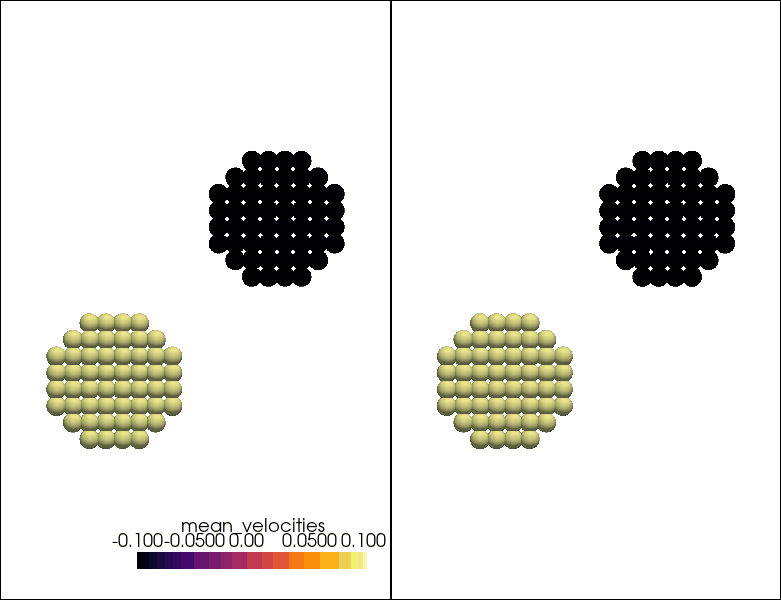

In [30]:
from IPython.display import Image
Image(filename="out.gif")